In [1]:
"""
we doin this thing
https://github.com/ContinuumIO/gtc2017-numba
"""

'\nwe doin this thing\nhttps://github.com/ContinuumIO/gtc2017-numba\n'

In [2]:
### TUTORIAL NOTEBOOK 1

In [3]:
# CUDA NOW
from numba import jit
import math

@jit
def hypot(x, y):
    # Implementation from https://en.wikipedia.org/wiki/Hypot
    x = abs(x);
    y = abs(y);
    t = min(x, y);
    x = max(x, y);
    t = t / x;
    return x * math.sqrt(1+t*t)

hypot(3.0, 4.0)

5.0

In [4]:
%timeit hypot.py_func(3.0, 4.0)

739 ns ± 4.33 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [5]:
@jit(nopython=True)
def ex1(x, y, out):
    for i in range(x.shape[0]):
        out[i] = hypot(x[i], y[i])

In [6]:
import numpy as np

in1 = np.arange(10, dtype=np.float64)
in2 = 2 * in1 + 1
out = np.empty_like(in1)

print('in1:', in1)
print('in2:', in2)

ex1(in1, in2, out)

print('out:', out)

in1: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
in2: [ 1.  3.  5.  7.  9. 11. 13. 15. 17. 19.]
out: [ 1.          3.16227766  5.38516481  7.61577311  9.8488578  12.08304597
 14.31782106 16.55294536 18.78829423 21.02379604]


In [7]:
np.testing.assert_almost_equal(out, np.hypot(in1, in2))

In [8]:
### TUTORIAL NOTEBOOK 2

In [25]:
import numpy as np

a = np.array([1, 2, 3, 4], dtype='int64')
b = np.array([10, 20, 30, 40], dtype='int64')

np.add(a, b)

array([11, 22, 33, 44], dtype=int64)

In [10]:
c = np.arange(4*4).reshape((4,4))
print('c:', c)

np.add(b, c)

c: [[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]


array([[10, 21, 32, 43],
       [14, 25, 36, 47],
       [18, 29, 40, 51],
       [22, 33, 44, 55]])

In [11]:
b_col = b[:, np.newaxis]
np.add(b_col, c)

array([[10, 11, 12, 13],
       [24, 25, 26, 27],
       [38, 39, 40, 41],
       [52, 53, 54, 55]])

In [48]:
from numba import vectorize

@vectorize(['int64(int64, int64)'], target='cuda')
def add_ufunc(x, y):
    return x + y
a = np.array([1, 2, 3, 4], dtype='int64')
b = np.array([10, 20, 30, 40], dtype='int64')
b_col = b[:, np.newaxis]
c = np.arange(4*4, dtype='int64').reshape((4,4))

print('a+b:\n', add_ufunc(a, b))
print()
print('b_col + c:\n', add_ufunc(b_col, c))
%timeit np.add(b_col, c)   # NumPy on CPU
%timeit add_ufunc(b_col, c) # Numba on GPU

C:\Users\User\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\numba\cuda\dispatcher.py:488: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


a+b:
 [11 22 33 44]

b_col + c:
 [[10 11 12 13]
 [24 25 26 27]
 [38 39 40 41]
 [52 53 54 55]]
1.39 µs ± 5.06 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
923 µs ± 23.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [49]:
from numba import vectorize

@vectorize(['int32(int32, int32)'], target='cuda')
def add_ufunc(x, y):
    return x + y
a = np.array([1, 2, 3, 4], dtype='int32')
b = np.array([10, 20, 30, 40], dtype='int32')
b_col = b[:, np.newaxis]
c = np.arange(4*4, dtype='int32').reshape((4,4))

print('a+b:\n', add_ufunc(a, b))
print()
print('b_col + c:\n', add_ufunc(b_col, c))
%timeit np.add(b_col, c)   # NumPy on CPU
%timeit add_ufunc(b_col, c) # Numba on GPU

a+b:
 [11 22 33 44]

b_col + c:
 [[10 11 12 13]
 [24 25 26 27]
 [38 39 40 41]
 [52 53 54 55]]


C:\Users\User\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\numba\cuda\dispatcher.py:488: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


1.39 µs ± 3.68 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
926 µs ± 22.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [53]:
import math  # Note that for the CUDA target, we need to use the scalar functions from the math module, not NumPy

SQRT_2PI = np.float32((2*math.pi)**0.5)  # Precompute this constant as a float32.  Numba will inline it at compile time.

@vectorize(['float32(float32, float32, float32)'], target='cuda')
def gaussian_pdf(x, mean, sigma):
    '''Compute the value of a Gaussian probability density function at x with given mean and sigma.'''
    return math.exp(-0.5 * ((x - mean) / sigma)**2) / (sigma * SQRT_2PI)
# Evaluate the Gaussian a million times!
x = np.random.uniform(-3, 3, size=1000000).astype(np.float32)
mean = np.float32(0.0)
sigma = np.float32(1.0)

# Quick test
gaussian_pdf(x[0], 0.0, 1.0)

C:\Users\User\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\numba\cuda\dispatcher.py:488: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


array([0.0273639])

In [54]:
import scipy.stats # for definition of gaussian distribution
norm_pdf = scipy.stats.norm
%timeit norm_pdf.pdf(x, loc=mean, scale=sigma)

33.6 ms ± 1.27 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [55]:
%timeit gaussian_pdf(x, mean, sigma)

4.98 ms ± 128 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [56]:
from numba import cuda

@cuda.jit(device=True)
def polar_to_cartesian(rho, theta):
    x = rho * math.cos(theta)
    y = rho * math.sin(theta)
    return x, y  # This is Python, so let's return a tuple

@vectorize(['float32(float32, float32, float32, float32)'], target='cuda')
def polar_distance(rho1, theta1, rho2, theta2):
    x1, y1 = polar_to_cartesian(rho1, theta1)
    x2, y2 = polar_to_cartesian(rho2, theta2)
    
    return ((x1 - x2)**2 + (y1 - y2)**2)**0.5

In [57]:
n = 1000000
rho1 = np.random.uniform(0.5, 1.5, size=n).astype(np.float32)
theta1 = np.random.uniform(-np.pi, np.pi, size=n).astype(np.float32)
rho2 = np.random.uniform(0.5, 1.5, size=n).astype(np.float32)
theta2 = np.random.uniform(-np.pi, np.pi, size=n).astype(np.float32)

polar_distance(rho1, theta1, rho2, theta2)

array([1.34777663, 0.18640072, 1.27148334, ..., 0.6589445 , 1.87648937,
       1.07449065])

In [62]:
polar_distance(rho1, theta1, rho2, theta2)

array([1.34777663, 0.18640072, 1.27148334, ..., 0.6589445 , 1.87648937,
       1.07449065])

In [ ]:
"""
LIST OF NUMBA THINGS THE GPU CAN DO
if/elif/else
while and for loops
Basic math operators
Selected functions from the math and cmath modules
Tuples

extra info here:
http://numba.pydata.org/numba-doc/latest/cuda/cudapysupported.html
"""

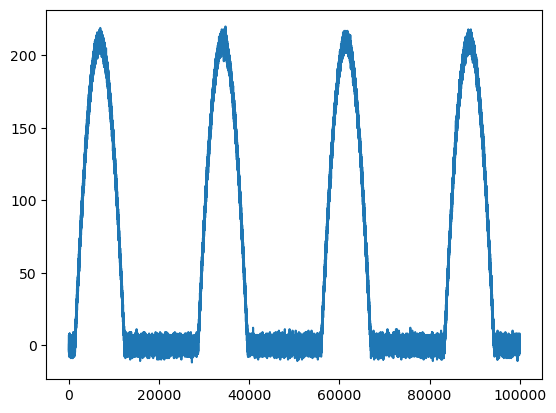

In [63]:
# Hacking up a noisy pulse train
%matplotlib inline
from matplotlib import pyplot as plt

n = 100000
noise = np.random.normal(size=n) * 3
pulses = np.maximum(np.sin(np.arange(n) / (n / 23)) - 0.3, 0.0)
waveform = ((pulses * 300) + noise).astype(np.int16)
plt.plot(waveform)

C:\Users\User\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\numba\cuda\dispatcher.py:488: NumbaPerformanceWarning: Grid size 98 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


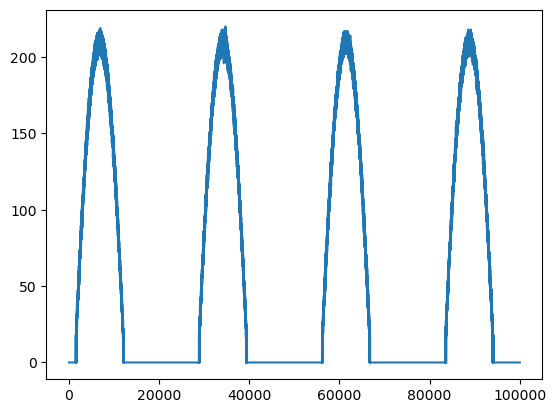

In [66]:
@vectorize(['int16(int16, int16)'], target='cuda')
def zero_suppress(waveform_value, threshold):
    ### Replace this implementation with yours
    if threshold < waveform_value:
        return waveform_value
    return 0
plt.plot(zero_suppress(waveform, 15.0))

In [ ]:
### TUTORIAL NOTEBOOK 3

In [69]:
from numba import vectorize
import numpy as np

@vectorize(['float32(float32, float32)'], target='cuda')
def add_ufunc(x, y):
    return x + y
n = 100000
x = np.arange(n).astype(np.float32)
y = 2 * x
%timeit add_ufunc(x, y)  # Baseline performance with host arrays

C:\Users\User\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\numba\cuda\dispatcher.py:488: NumbaPerformanceWarning: Grid size 98 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


1.19 ms ± 1.65 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [70]:
x_device = cuda.to_device(x)
y_device = cuda.to_device(y)

print(x_device)
print(x_device.shape)
print(x_device.dtype)

(100000,)
float32


In [71]:
%timeit add_ufunc(x_device, y_device)

657 µs ± 13.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [72]:
out_device = cuda.device_array(shape=(n,), dtype=np.float32)  # does not initialize the contents, like np.empty()

In [73]:
%timeit add_ufunc(x_device, y_device, out=out_device)

511 µs ± 14.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [74]:
out_host = out_device.copy_to_host()
print(out_host[:10])

[ 0.  3.  6.  9. 12. 15. 18. 21. 24. 27.]


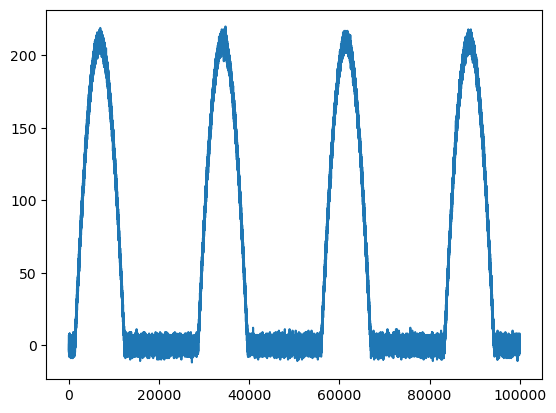

In [82]:
# Convert this code to use device allocations so that there are
# only host<->device copies at the beginning and end and benchmark performance change:

# DIDN'T DO IT, CAN'T BE BOTHERED

import math

@vectorize(['float32(float32, float32, float32)'], target='cuda')
def make_pulses(i, period, amplitude):
    return max(math.sin(i / period) - 0.3, 0.0) * amplitude

n = 100000
noise = (np.random.normal(size=n) * 3).astype(np.float32)
t = np.arange(n, dtype=np.float32)
period = n / 23

#pulses = make_pulses(t, period, 100.0)
#aveform = add_ufunc(pulses, noise)                  THIS LINE MAKES IT NOT WORK. CAN'T BE BOTHERED TO FIX IT

%matplotlib inline
from matplotlib import pyplot as plt
plt.plot(waveform)

In [ ]:
### TUTORIAL NOTEBOOK 4

In [83]:
from numba import cuda

@cuda.jit
def add_kernel(x, y, out):
    tx = cuda.threadIdx.x # this is the unique thread ID within a 1D block
    ty = cuda.blockIdx.x  # Similarly, this is the unique block ID within the 1D grid

    block_size = cuda.blockDim.x  # number of threads per block
    grid_size = cuda.gridDim.x    # number of blocks in the grid
    
    start = tx + ty * block_size
    stride = block_size * grid_size

    # assuming x and y inputs are same length
    for i in range(start, x.shape[0], stride):
        out[i] = x[i] + y[i]

In [84]:
import numpy as np

n = 100000
x = np.arange(n).astype(np.float32)
y = 2 * x
out = np.empty_like(x)

threads_per_block = 128
blocks_per_grid = 30

add_kernel[blocks_per_grid, threads_per_block](x, y, out)
print(out[:10])

[ 0.  3.  6.  9. 12. 15. 18. 21. 24. 27.]


C:\Users\User\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\numba\cuda\dispatcher.py:488: NumbaPerformanceWarning: Grid size 30 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
C:\Users\User\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\numba\cuda\cudadrv\devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


In [ ]:
"""
thread block helper functions:
http://numba.pydata.org/numba-doc/dev/cuda/kernels.html#absolute-positions
"""

In [85]:
@cuda.jit
def add_kernel(x, y, out):
    start = cuda.grid(1)      # 1 = one dimensional thread grid, returns a single value
    stride = cuda.gridsize(1) # ditto

    # assuming x and y inputs are same length
    for i in range(start, x.shape[0], stride):
        out[i] = x[i] + y[i]

In [86]:
x_device = cuda.to_device(x)
y_device = cuda.to_device(y)
out_device = cuda.device_array_like(x)

%timeit add_kernel[blocks_per_grid, threads_per_block](x, y, out)

%timeit add_kernel[blocks_per_grid, threads_per_block](x_device, y_device, out_device); out_device.copy_to_host()

C:\Users\User\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\numba\cuda\dispatcher.py:488: NumbaPerformanceWarning: Grid size 30 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
C:\Users\User\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\numba\cuda\cudadrv\devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


2.04 ms ± 53.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
207 µs ± 7.77 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [ ]:
"""
it's possible to run multiple kernels in parallal using something called 'cuda streams'
http://numba.pydata.org/numba-doc/dev/cuda-reference/host.html?highlight=synchronize#stream-management
"""

In [88]:
# CPU input/output arrays, implied synchronization for memory copies
%time add_kernel[blocks_per_grid, threads_per_block](x, y, out)

CPU times: total: 0 ns
Wall time: 3 ms


In [89]:
# GPU input/output arrays, no synchronization (but force sync before and after)
cuda.synchronize()
%time add_kernel[blocks_per_grid, threads_per_block](x_device, y_device, out_device)
cuda.synchronize()

CPU times: total: 0 ns
Wall time: 1 ms


In [91]:
# GPU input/output arrays, include explicit synchronization in timing
cuda.synchronize()
%time add_kernel[blocks_per_grid, threads_per_block](x_device, y_device, out_device); cuda.synchronize()

CPU times: total: 0 ns
Wall time: 0 ns


In [ ]:
"""
ATOMIC OPERATORS
http://numba.pydata.org/numba-doc/dev/cuda/intrinsics.html#supported-atomic-operations
"""

In [92]:
@cuda.jit
def thread_counter_race_condition(global_counter):
    global_counter[0] += 1  # This is bad
    
@cuda.jit
def thread_counter_safe(global_counter):
    cuda.atomic.add(global_counter, 0, 1)  # Safely add 1 to offset 0 in global_counter array

In [97]:
# This gets the wrong answer
global_counter = cuda.to_device(np.array([0], dtype=np.int32))
thread_counter_race_condition[64, 64](global_counter)

print('Should be %d:' % (64*64), global_counter.copy_to_host())

Should be 4096: [1]


In [98]:
# This works correctly
global_counter = cuda.to_device(np.array([0], dtype=np.int32))
thread_counter_safe[64, 64](global_counter)

print('Should be %d:' % (64*64), global_counter.copy_to_host())

Should be 4096: [4096]


C:\Users\User\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\numba\cuda\dispatcher.py:488: NumbaPerformanceWarning: Grid size 64 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


In [ ]:
# https://github.com/ContinuumIO/gtc2017-numba/blob/master/4%20-%20Writing%20CUDA%20Kernels.ipynb
# there's an exercise here you didn't bother to do coz fuk it

In [ ]:
### TUTORIAL NOTEBOOK 5
# bruh idk, maybe look at this later
# it's about debugging

### TUTORIAL NOTEBOOK 6
# also has some neat stuff, maybe check it again later
# random numbers, shared memory in thread blocks, and generalized Ufunc